# Active Learning - Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [27]:
%run set_environment

## Bibliotecas

In [28]:
#importing_libraries.py

import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [29]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from copy import deepcopy

In [141]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn import preprocessing

In [32]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [33]:
from timeit import default_timer as timer

In [34]:
from scipy.io import arff

## Classificadores

### Algoritmos

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#TO DO mais classificadores

### Conjunto de dados

In [36]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

In [37]:
# Datasets OpenML
import openml
import os

In [38]:
openml.config.cache_directory = os.path.expanduser('./datasets/openML')
openml_list = openml.datasets.list_datasets()

datalist = pd.DataFrame.from_dict(openml_list, orient="index")
datalist = list(datalist[(datalist.NumberOfClasses.isnull() == False) & (datalist.NumberOfClasses != 0)]["did"])

## Estatratégias

### Amostra por incerteza

In [66]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
    
    from modAL.uncertainty import classifier_uncertainty
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    X_test, y_test = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    sample_size = sample_size + len(X_train)

    #cls = which_classifier(classifier)
    #cls.fit(X_train,y_train)

    learner = ActiveLearner (
        estimator= which_classifier(classifier), #cls,
        query_strategy=uncertainty_sampling,
        X_training = X_train, y_training = y_train # AL AJUSTA O CLASSIFIER 
    )
    
    uncertain_sample_score = learner.score(X_test, y_test)
    performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][idx]], y_raw[idx_data[idx_bag][TRAIN][idx]]
        
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2:
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
            uncertain_sample_score = learner.score(X_test, y_test)
            performance_history.append(uncertain_sample_score)
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Uncertain Sampling"}

### Amostragem aleatória

In [60]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    for i in range(1, cost+1):

        #high = X_raw.shape[0] = qtd amostras no dataset
        training_indices = np.random.randint(low=0, high=len(X_raw[idx_data[idx_bag][TRAIN]]), size=k+i) #high = qtd elementos na bag
        sample_size = sample_size + len(training_indices)

        X_train = X_raw[idx_data[idx_bag][TRAIN][training_indices]] #ASK06
        y_train = y_raw[idx_data[idx_bag][TRAIN][training_indices]]

        X_test = np.delete(X_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)
        y_test = np.delete(y_raw, idx_data[idx_bag][TRAIN][training_indices], axis=0)

        cls = which_classifier(classifier)
        cls.fit(X_train, y_train)

        random_sampling_score = cls.score(X_test,y_test)
        performance_history.append(random_sampling_score)

        
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size,
             "Strategy": "Random Sampling"}

### Consulta por comitê

In [69]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    learner_list = []

    for j in range(1, cost+1): # Loop para criação do comitê

        X_train, _, y_train, _ = train_test_split(X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]], test_size=0.97)
        sample_size = sample_size + len(X_train)

        # initializing learner
        learner = ActiveLearner(
            estimator= which_classifier(classifier),
            query_strategy=uncertainty_sampling,
            X_training = X_train, y_training = y_train 
        )
        learner_list.append(learner)

    # assembling the committee
    committee = Committee(
        learner_list=learner_list,
        query_strategy=vote_entropy_sampling)

    X_pool, y_pool = X_raw[idx_data[idx_bag][TRAIN]], y_raw[idx_data[idx_bag][TRAIN]]

    # query by committee
    for idx in range(cost):
        query_idx, query_instance = committee.query(X_pool, n_instances = k+1)
        sample_size = sample_size + len(query_idx)
        committee.teach(
            X=X_pool[query_idx],
            y=y_pool[query_idx]
        )

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)            
        query_by_committee_score = committee.score(X_pool, y_pool)
        performance_history.append(query_by_committee_score)

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size,
             "Strategy": "Query by Committee"}

### Expected Error Reduction

In [72]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][TRAIN])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][TRAIN][initial_idx]], y_raw[idx_data[idx_bag][TRAIN][initial_idx]]
    X_pool, y_pool = X_raw[idx_data[idx_bag][TEST]], y_raw[idx_data[idx_bag][TEST]]
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    exp_er_score = learner.score(X_pool, y_pool)
    performance_history.append(exp_er_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)[0]

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
    
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        
        exp_er_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_er_score)
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Error Reduction"}

### Expected Model Change

In [73]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, cost):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_pool, y_pool = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator = which_classifier(classifier),
        X_training = X_train, y_training = y_train
    )
    
#     performance_history.append(uncertain_sample_score)

    total_of_samples = 1
    while (total_of_samples != cost):
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)

        if score_aux > score_learner:
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        
        exp_mo_score = learner.score(X_pool, y_pool)
        performance_history.append(exp_mo_score)

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history[-1], 
             "time_elapsed": time_elapsed,
             "classifier": classifier,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": "Expected Model Change"}

## Setup

In [41]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [140]:
def which_oml_dataset(dataset_id, n_splits = 5):
    data = openml.datasets.get_dataset(dataset_id)
    
    X_raw, y_raw, categorical_indicator, attribute_names = data.get_data(
    dataset_format="array", target=data.default_target_attribute)
    
    le = preprocessing.LabelEncoder()
    le.fit(y_raw)
    y_raw = le.transform(y_raw)
    
    X_raw = np.nan_to_num(X_raw)
    
    data_cv = StratifiedShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, data.name

In [43]:
def which_arff_dataset(dataset, n_splits = 5):
   
    from sklearn.preprocessing import OrdinalEncoder
    
    data = arff.loadarff('datasets/luis/' + dataset)
    data = pd.DataFrame(data[0])

    X_raw = data[data.columns[:-1]].to_numpy()
    y_raw = data[data.columns[-1]].to_numpy()
    
    lex = preprocessing.OrdinalEncoder()
    lex.fit(X_raw)
    X_raw = lex.transform(X_raw)
        
    ley = preprocessing.LabelEncoder()
    ley.fit(y_raw)
    y_raw = ley.transform(y_raw)
    
    # cross validation bags
    data_cv = ShuffleSplit(n_splits= n_splits, train_size=0.7, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data, dataset

In [44]:
def which_classifier(classifier = '5NN'):
    
    if (classifier == '5NN'):
        return KNeighborsClassifier(5)
    elif (classifier == 'C4.5'):
        return tree.DecisionTreeClassifier()
    elif (classifier == 'NB'):
        return GaussianNB()
    elif (classifier == 'SVM'):
        return SVC(probability=True, gamma='auto')
    elif (classifier == 'RF'):
        return RandomForestClassifier()

In [142]:
#Teste

total_performance_history = []

classifiers = ['5NN']
ds = '3_kr-vs-kp.arff'
for classifier in classifiers:
    X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)
    for idx_bag in range(n_splits):
        print(ds, classifier, " ", idx_bag, " ", n_splits, " uncertain_sampling")
        result = exp_model_change(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
        result['dataset'] = ds
        total_performance_history.append(result)

/home/ahmoura/ProgramFiles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


3_kr-vs-kp.arff 5NN   0   5  uncertain_sampling
3_kr-vs-kp.arff 5NN   1   5  uncertain_sampling
3_kr-vs-kp.arff 5NN   2   5  uncertain_sampling
3_kr-vs-kp.arff 5NN   3   5  uncertain_sampling
3_kr-vs-kp.arff 5NN   4   5  uncertain_sampling


In [134]:
datasets = os.listdir('./datasets/luis')
classifiers = ['5NN', 'C4.5', 'NB','RF']
total_performance_history = []

for ds in datasets:
    for classifier in classifiers:
        X_raw, y_raw, idx_data, dataset_name = which_arff_dataset(ds)

        #para cada i em idx_bag ("n_splits") (1 a 5)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", cls, " ", idx_bag, " ", n_splits, " uncertain_sampling")
            result = uncertain_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", cls, " ", idx_bag, " ", n_splits, " random sampling")
            result = random_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", cls, " ", idx_bag, " ", n_splits, " query_by_committee")
            result = query_by_committee(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, cls, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", cls, " ", idx_bag, " ", n_splits, " exp error reduction")
            result = exp_error_reduction(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)
        for idx_bag in range(n_splits):
            print(ds[:-5], " ", cls, " ", idx_bag, " ", n_splits, " exp model change")
            result = exp_model_change(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, cost)
            result['dataset'] = ds[:-5]
            total_performance_history.append(result)

/home/ahmoura/ProgramFiles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


21_car   RF   0   5  uncertain_sampling
21_car   RF   1   5  uncertain_sampling
21_car   RF   2   5  uncertain_sampling
21_car   RF   3   5  uncertain_sampling
21_car   RF   4   5  uncertain_sampling
21_car   RF   0   5  random sampling
21_car   RF   1   5  random sampling
21_car   RF   2   5  random sampling
21_car   RF   3   5  random sampling


KeyboardInterrupt: 

In [143]:
total_performance_history

[{'performance_history': 0.665625,
  'time_elapsed': 0.5309280719993694,
  'classifier': '5NN',
  'sample_size': 20,
  'Strategy': 'Expected Model Change',
  'dataset': '3_kr-vs-kp.arff'},
 {'performance_history': 0.725,
  'time_elapsed': 0.6286431370008358,
  'classifier': '5NN',
  'sample_size': 30,
  'Strategy': 'Expected Model Change',
  'dataset': '3_kr-vs-kp.arff'},
 {'performance_history': 0.709375,
  'time_elapsed': 0.6553730640007416,
  'classifier': '5NN',
  'sample_size': 35,
  'Strategy': 'Expected Model Change',
  'dataset': '3_kr-vs-kp.arff'},
 {'performance_history': 0.74375,
  'time_elapsed': 0.6005525649998162,
  'classifier': '5NN',
  'sample_size': 30,
  'Strategy': 'Expected Model Change',
  'dataset': '3_kr-vs-kp.arff'},
 {'performance_history': 0.725,
  'time_elapsed': 0.5568398659997911,
  'classifier': '5NN',
  'sample_size': 25,
  'Strategy': 'Expected Model Change',
  'dataset': '3_kr-vs-kp.arff'}]

## Visualization

### Preprocessing

In [136]:
df = pd.DataFrame.from_dict(total_performance_history)

In [137]:
df = df.explode('performance_history')

In [138]:
df[df.Strategy != "Query by Committee"].sort_values('performance_history', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset
3,0.722543,0.024729,5NN,5,Uncertain Sampling,21_car
2,0.699422,0.028306,5NN,5,Uncertain Sampling,21_car
0,0.693642,0.025219,5NN,5,Uncertain Sampling,21_car
4,0.687861,0.028900,5NN,5,Uncertain Sampling,21_car
5,0.685931,1.279993,5NN,105,Random Sampling,21_car
1,0.647399,0.028416,5NN,5,Uncertain Sampling,21_car
6,0.614352,1.140842,5NN,105,Random Sampling,21_car
7,0.573847,1.134568,5NN,105,Random Sampling,21_car


In [139]:
df[df.Strategy == "Expected Error Reduction"].sort_values('time_elapsed', ascending = False)

,performance_history,time_elapsed,classifier,sample_size,Strategy,dataset


In [ ]:
df.info()

### Plots

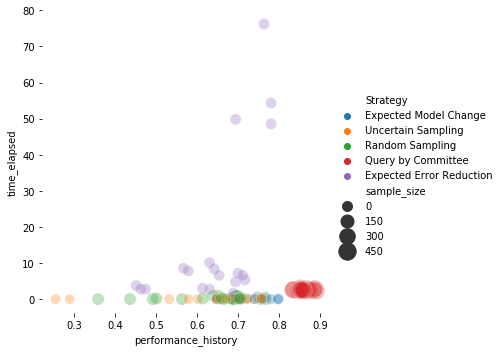

In [115]:
g = sns.relplot(
    data= df,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=5), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

In [ ]:
g = sns.relplot(
    data= df[(df.Strategy != "Uncertain Sampling") & (df.Strategy != "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

In [ ]:
g = sns.relplot(
    data= df[(df.Strategy == "Uncertain Sampling") | (df.Strategy == "Query by Committee")],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=2), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

## Baixando datasets

In [ ]:
from tqdm.notebook import tqdm, trange
p_bar = tqdm(datalist)
for dataset_id in p_bar:
    X_raw, y_raw, idx_data, dataset_name = which_oml_dataset(dataset_id)
    p_bar.set_description(f'"{dataset_name}"')